# Descripción

La compañía de seguros Sure Tomorrow quiere resolver varias tareas con la ayuda de machine learning y te pide que evalúes esa posibilidad.
- Tarea 1: encontrar clientes que sean similares a un cliente determinado. Esto ayudará a los agentes de la compañía con el marketing.
- Tarea 2: predecir la probabilidad de que un nuevo cliente reciba una prestación del seguro. ¿Puede un modelo de predictivo funcionar mejor que un modelo dummy?
- Tarea 3: predecir el número de prestaciones de seguro que un nuevo cliente pueda recibir utilizando un modelo de regresión lineal.
- Tarea 4: proteger los datos personales de los clientes sin afectar al modelo del ejercicio anterior. Es necesario desarrollar un algoritmo de transformación de datos que dificulte la recuperación de la información personal si los datos caen en manos equivocadas. Esto se denomina enmascaramiento u ofuscación de datos. Pero los datos deben protegerse de tal manera que no se vea afectada la calidad de los modelos de machine learning. No es necesario elegir el mejor modelo, basta con demostrar que el algoritmo funciona correctamente.


# Preprocesamiento y exploración de datos

## Inicialización

In [1]:
#pip install plotly_express

In [2]:
import math
import numpy as np
import pandas as pd

import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns

import sklearn.linear_model
import sklearn.metrics
import sklearn.neighbors
import sklearn.preprocessing

from sklearn.model_selection import train_test_split



## Carga de datos

Carga los datos y haz una revisión básica para comprobar que no hay problemas obvios.

In [3]:
data = pd.read_csv('https://practicum-content.s3.us-west-1.amazonaws.com/datasets/insurance_us.csv')

Renombramos las columnas para que el código se vea más coherente con su estilo.

In [4]:
data = data.rename(columns={'Gender': 'gender', 'Age': 'age', 'Salary': 'income', 'Family members': 'family_members', 'Insurance benefits': 'insurance_benefits'})

In [5]:
data.sample(10)

,gender,age,income,family_members,insurance_benefits
4932,0,38.0,45700.0,2,0
1301,1,20.0,52300.0,1,0
3491,1,31.0,44400.0,3,0
1666,0,36.0,31700.0,1,0
566,0,21.0,34300.0,0,0
44,0,30.0,31600.0,2,0
1027,0,37.0,59900.0,1,0
4532,0,30.0,40400.0,0,0
3955,0,43.0,43900.0,0,1
1373,0,40.0,52000.0,0,0


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              5000 non-null   int64  
 1   age                 5000 non-null   float64
 2   income              5000 non-null   float64
 3   family_members      5000 non-null   int64  
 4   insurance_benefits  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


In [7]:
# puede que queramos cambiar el tipo de edad (de float a int) aunque esto no es crucial
# escribe tu conversión aquí si lo deseas:
data["age"] = data["age"].astype("int")


In [8]:
# comprueba que la conversión se haya realizado con éxito
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              5000 non-null   int64  
 1   age                 5000 non-null   int32  
 2   income              5000 non-null   float64
 3   family_members      5000 non-null   int64  
 4   insurance_benefits  5000 non-null   int64  
dtypes: float64(1), int32(1), int64(3)
memory usage: 175.9 KB


In [9]:
# ahora echa un vistazo a las estadísticas descriptivas de los datos.# ¿Se ve todo bien?
data.describe()

,gender,age,income,family_members,insurance_benefits
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.499000,30.952800,39916.360000,1.194200,0.148000
std,0.500049,8.440807,9900.083569,1.091387,0.463183
min,0.000000,18.000000,5300.000000,0.000000,0.000000
25%,0.000000,24.000000,33300.000000,0.000000,0.000000
50%,0.000000,30.000000,40200.000000,1.000000,0.000000
75%,1.000000,37.000000,46600.000000,2.000000,0.000000
max,1.000000,65.000000,79000.000000,6.000000,5.000000


## Análisis exploratorio de datos

Vamos a comprobar rápidamente si existen determinados grupos de clientes observando el gráfico de pares.

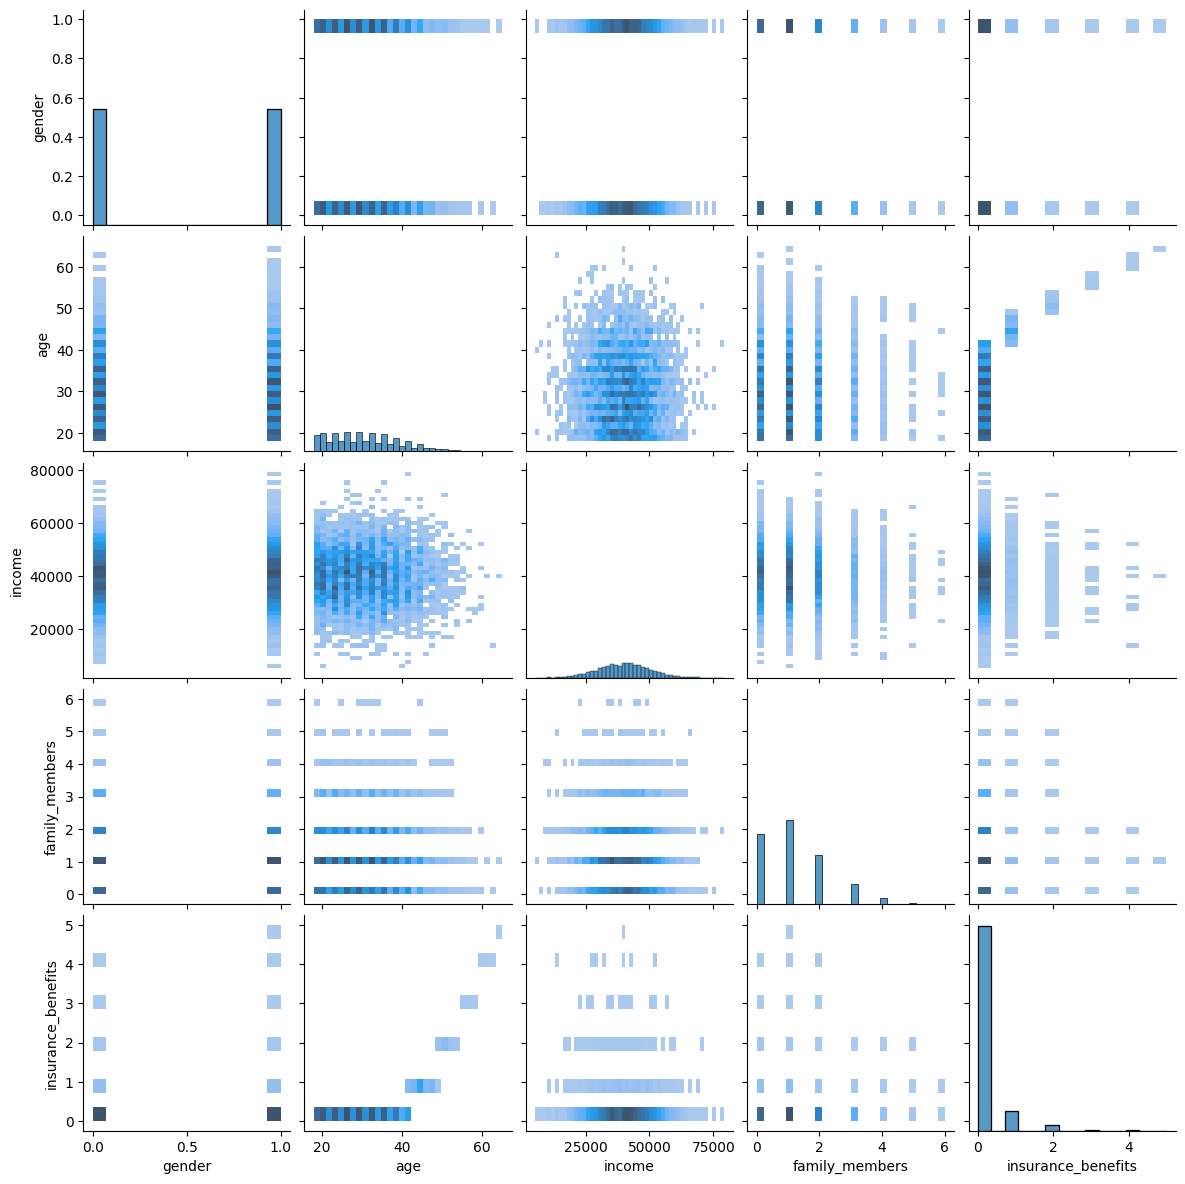

In [10]:
g = sns.pairplot(data, kind='hist')
g.fig.set_size_inches(12, 12)

In [11]:
#Heatmap para la correlación de nuestras variables
px.imshow(data.corr(), text_auto=True, aspect="auto").show()

<div class="alert alert-block alert-danger">
<b>Comentario del revisor</b> <a class="tocSkip"></a>
    
Debemos asegurarnos de que todo nuestro proyecto se ejecute. Ten presente que debemos también asegurarnos de que las versiones de los paquetes que utilicemos deben ser las mismas para que en la plataforma no haya ningún inconveniente.
</div>


In [12]:
#grafico 3d para corroborar la relación de "insurance_bemefits" y "age"
data['insurance_benefits_received'] = np.where(data['insurance_benefits'] > 0, 1, 0)

fig = px.scatter_3d(data,
                    x='family_members', y='age', z='income',
                    color='insurance_benefits_received', symbol='gender',
                    opacity=1)
fig.show()

# Tarea 1. Clientes similares

En el lenguaje de ML, es necesario desarrollar un procedimiento que devuelva los k vecinos más cercanos (objetos) para un objeto dado basándose en la distancia entre los objetos.
Es posible que quieras revisar las siguientes lecciones (capítulo -> lección)- Distancia entre vectores -> Distancia euclidiana
- Distancia entre vectores -> Distancia Manhattan

Para resolver la tarea, podemos probar diferentes métricas de distancia.

Escribe una función que devuelva los k vecinos más cercanos para un $n^{th}$ objeto basándose en una métrica de distancia especificada. A la hora de realizar esta tarea no debe tenerse en cuenta el número de prestaciones de seguro recibidas.
Puedes utilizar una implementación ya existente del algoritmo kNN de scikit-learn (consulta [el enlace](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html#sklearn.neighbors.NearestNeighbors)) o tu propia implementación.
Pruébalo para cuatro combinaciones de dos casos- Escalado
  - los datos no están escalados
  - los datos se escalan con el escalador [MaxAbsScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MaxAbsScaler.html)
- Métricas de distancia
  - Euclidiana
  - Manhattan

Responde a estas preguntas:- ¿El hecho de que los datos no estén escalados afecta al algoritmo kNN? Si es así, ¿cómo se manifiesta?- ¿Qué tan similares son los resultados al utilizar la métrica de distancia Manhattan (independientemente del escalado)?

In [13]:
def get_knn(df : pd.DataFrame, n : int, k : int, metric : str):
    
    """
    Devuelve los k vecinos más cercanos

    :param df: DataFrame de pandas utilizado para encontrar objetos similares dentro del mismo lugar    :param n: número de objetos para los que se buscan los vecinos más cercanos    :param k: número de vecinos más cercanos a devolver
    :param métrica: nombre de la métrica de distancia    """

    feature_names = ['gender', 'age', 'income', 'family_members']

    nbrs = sklearn.neighbors.NearestNeighbors(n_neighbors=k, metric= metric, )
    features = df.loc[:,feature_names]
    target = df["insurance_benefits"]
    nbrs.fit(features)
    # <tu código aquí> 

    nbrs_distances, nbrs_indices = nbrs.kneighbors([df.iloc[n][feature_names]], k, return_distance=True)
    
    df_res = pd.concat([
        df.iloc[nbrs_indices[0]], 
        pd.DataFrame(nbrs_distances.T, index=nbrs_indices[0], columns=['distance'])
        ], axis=1)
    
    return df_res

Escalar datos.

In [14]:
feature_names = ['gender', 'age', 'income', 'family_members']

transformer_mas = sklearn.preprocessing.MaxAbsScaler().fit(data[feature_names].to_numpy())

data_scaled = data.copy()
data_scaled.loc[:, feature_names] = transformer_mas.transform(data[feature_names].to_numpy())

In [15]:
data_scaled.sample(5)

,gender,age,income,family_members,insurance_benefits,insurance_benefits_received
3075,0,0.615385,0.543038,0.333333,0,0
4718,0,0.369231,0.450633,0.000000,0,0
4769,1,0.307692,0.740506,0.166667,0,0
2923,0,0.676923,0.493671,0.333333,1,1
3200,0,0.507692,0.518987,0.166667,0,0


Ahora, vamos a obtener registros similares para un cliente determinado

In [16]:
get_knn(data, 1005, 5, "euclidean")

c:\Users\Jorge Armando\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning:

X does not have valid feature names, but NearestNeighbors was fitted with feature names



,gender,age,income,family_members,insurance_benefits,insurance_benefits_received,distance
1005,1,34,21500.0,1,0,0,0.000000
1412,1,30,21500.0,2,0,0,4.123106
2678,1,28,21500.0,2,0,0,6.082763
2955,1,32,21600.0,0,0,0,100.024997
2988,1,32,21600.0,0,0,0,100.024997


In [17]:
get_knn(data_scaled, 1005, 5, "euclidean")

c:\Users\Jorge Armando\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning:

X does not have valid feature names, but NearestNeighbors was fitted with feature names



,gender,age,income,family_members,insurance_benefits,insurance_benefits_received,distance
1005,1,0.523077,0.272152,0.166667,0,0,0.000000
418,1,0.507692,0.278481,0.166667,0,0,0.016636
4529,1,0.538462,0.279747,0.166667,0,0,0.017157
1589,1,0.538462,0.291139,0.166667,0,0,0.024438
2665,1,0.538462,0.297468,0.166667,0,0,0.029624


In [18]:
get_knn(data, 1005, 5, "manhattan")

c:\Users\Jorge Armando\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning:

X does not have valid feature names, but NearestNeighbors was fitted with feature names



,gender,age,income,family_members,insurance_benefits,insurance_benefits_received,distance
1005,1,34,21500.0,1,0,0,0.0
1412,1,30,21500.0,2,0,0,5.0
2678,1,28,21500.0,2,0,0,7.0
2955,1,32,21600.0,0,0,0,103.0
2988,1,32,21600.0,0,0,0,103.0


In [19]:
get_knn(data_scaled, 1005, 5, "manhattan")

c:\Users\Jorge Armando\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning:

X does not have valid feature names, but NearestNeighbors was fitted with feature names



,gender,age,income,family_members,insurance_benefits,insurance_benefits_received,distance
1005,1,0.523077,0.272152,0.166667,0,0,0.000000
418,1,0.507692,0.278481,0.166667,0,0,0.021714
4529,1,0.538462,0.279747,0.166667,0,0,0.022980
4525,1,0.523077,0.302532,0.166667,0,0,0.030380
1589,1,0.538462,0.291139,0.166667,0,0,0.034372


Respuestas a las preguntas

**¿El hecho de que los datos no estén escalados afecta al algoritmo kNN? Si es así, ¿cómo se manifiesta?** 

Sí afecta, el escalamiento de los datos nos sirve para que ningún feature tenga más peso que otro, en este caso si no escalamos los datos la columna de "income" toma más relevancia que los demás datos, y es el unico valor al que la función da peso al hacer la búsqueda

**¿Qué tan similares son los resultados al utilizar la métrica de distancia Manhattan (independientemente del escalado)?** 

Son bastante parecidos, casi todos los vecionos son los mismos, o con valores muy parecidos

<div class="alert alert-block alert-success">
<b>Comentario del revisor</b> <a class="tocSkip"></a>

¡Perfecto! Los modelos basados en distancias son sensibles a las unidades de medida. Lo mejor será siempre hacerlos comparables a través de algún tipo de escalamiento.
</div>


# Tarea 2. ¿Es probable que el cliente reciba una prestación del seguro?

En términos de machine learning podemos considerarlo como una tarea de clasificación binaria.

Con el valor de `insurance_benefits` superior a cero como objetivo, evalúa si el enfoque de clasificación kNN puede funcionar mejor que el modelo dummy.
Instrucciones:
- Construye un clasificador basado en KNN y mide su calidad con la métrica F1 para k=1...10 tanto para los datos originales como para los escalados. Sería interesante observar cómo k puede influir en la métrica de evaluación y si el escalado de los datos provoca alguna diferencia. Puedes utilizar una implementación ya existente del algoritmo de clasificación kNN de scikit-learn (consulta [el enlace](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)) o tu propia implementación.- Construye un modelo dummy que, en este caso, es simplemente un modelo aleatorio. Debería devolver "1" con cierta probabilidad. Probemos el modelo con cuatro valores de probabilidad: 0, la probabilidad de pagar cualquier prestación del seguro, 0.5, 1.
La probabilidad de pagar cualquier prestación del seguro puede definirse como
$$
P\{\text{prestación de seguro recibida}\}=\frac{\text{número de clientes que han recibido alguna prestación de seguro}}{\text{número total de clientes}}.
$$

Divide todos los datos correspondientes a las etapas de entrenamiento/prueba respetando la proporción 70:30.

In [20]:
# сalcula el objetivo
data_scaled['insurance_benefits_received'] = np.where(data_scaled['insurance_benefits'] > 0, 1, 0)
data['insurance_benefits_received'] = np.where(data['insurance_benefits'] > 0, 1, 0)

data_scaled.sample(10)

,gender,age,income,family_members,insurance_benefits,insurance_benefits_received
3568,1,0.492308,0.562025,0.000000,0,0
2821,0,0.676923,0.726582,0.500000,1,1
1652,0,0.400000,0.668354,0.500000,0,0
1241,0,0.538462,0.483544,0.166667,0,0
279,0,0.353846,0.437975,0.500000,0,0
2510,1,0.507692,0.301266,0.166667,0,0
2531,0,0.476923,0.573418,0.166667,0,0
2072,0,0.292308,0.406329,0.000000,0,0
2725,0,0.461538,0.470886,0.000000,0,0
4457,0,0.415385,0.406329,0.333333,0,0


In [21]:
# comprueba el desequilibrio de clases con value_counts()
data_scaled["insurance_benefits_received"].value_counts()


insurance_benefits_received
0    4436
1     564
Name: count, dtype: int64

#### Defiinición de funciones

In [22]:
"""
Predecir k-NN de un dataset dado
"""
def pred_kNN(df : pd.DataFrame, n_neighbors=5, algorithm='auto', metric='minkowski', seed = 99):

    np.random.seed(seed)
    
    features = df.drop(["insurance_benefits","insurance_benefits_received"], axis = 1)
    target = df["insurance_benefits_received"]
    features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=0.25)

    model = sklearn.neighbors.KNeighborsClassifier(n_neighbors = n_neighbors, algorithm = algorithm, metric = metric)
    model.fit(features_train,target_train)
    predictions = model.predict(features_valid)
    probab = model.predict_proba(features_valid) 
    return predictions, target_valid, probab


"""
Evaluador del modelo
"""
def eval_classifier(y_true, y_pred):
    
    f1_score = sklearn.metrics.f1_score(y_true, y_pred)
    print(f'F1: {f1_score:.2f}')
    cm = sklearn.metrics.confusion_matrix(y_true, y_pred, normalize='all')
    print('Matriz de confusión')
    print(cm)


"""
 generar la salida de un modelo aleatorio
"""
def rnd_model_predict(P, size, seed=42):

    rng = np.random.default_rng(seed=seed)
    return rng.binomial(n=1, p=P, size=size)

In [23]:
#Obtenemos nuestros resultados escalados
results_k = []
for k in range(1, 10, 1):
    y_pred, y_true, probab = pred_kNN(data_scaled, n_neighbors = k)
    k_dict = {
        "k":k,
        "predictions":y_pred,
        "true_values": y_true,
        "probabilities":probab
    }
    results_k.append(k_dict)
    print(f"K:  {k}")
    eval_classifier(y_pred, y_true)

#Obtenemos nuestros resultados no escalados
results_k_not_scaled = []
for k in range(1, 10, 1):
    y_pred, y_true, probab = pred_kNN(data, n_neighbors = k)
    k_dict = {
        "k":k,
        "predictions":y_pred,
        "true_values": y_true,
        "probabilities":probab
    }
    results_k.append(k_dict)
    print(f"K:  {k}")
    eval_classifier(y_pred, y_true)

K:  1
F1: 0.96
Matriz de confusión
[[0.8808 0.008 ]
 [0.0016 0.1096]]
K:  2
F1: 0.92
Matriz de confusión
[[0.8824 0.0176]
 [0.     0.1   ]]
K:  3
F1: 0.94
Matriz de confusión
[[0.88   0.0112]
 [0.0024 0.1064]]
K:  4
F1: 0.92
Matriz de confusión
[[0.8824 0.0184]
 [0.     0.0992]]
K:  5
F1: 0.93
Matriz de confusión
[[0.8808 0.0144]
 [0.0016 0.1032]]
K:  6
F1: 0.90
Matriz de confusión
[[8.816e-01 2.080e-02]
 [8.000e-04 9.680e-02]]
K:  7
F1: 0.92
Matriz de confusión
[[0.88   0.016 ]
 [0.0024 0.1016]]
K:  8
F1: 0.89
Matriz de confusión
[[0.8824 0.0224]
 [0.     0.0952]]
K:  9
F1: 0.92
Matriz de confusión
[[0.8824 0.0184]
 [0.     0.0992]]
K:  1
F1: 0.67
Matriz de confusión
[[0.8656 0.0496]
 [0.0168 0.068 ]]
K:  2
F1: 0.42
Matriz de confusión
[[0.8776 0.0848]
 [0.0048 0.0328]]
K:  3
F1: 0.42
Matriz de confusión
[[0.872  0.0832]
 [0.0104 0.0344]]
K:  4
F1: 0.23
Matriz de confusión
[[0.8784 0.1016]
 [0.004  0.016 ]]
K:  5
F1: 0.25
Matriz de confusión
[[0.876  0.1   ]
 [0.0064 0.0176]]
K:  6
F1

In [24]:
for P in [0, data_scaled['insurance_benefits_received'].sum() / len(data_scaled), 0.5, 1]:

    print(f'La probabilidad: {P:.2f}')
    y_pred_rnd = rnd_model_predict(P, len(data_scaled))
        
    eval_classifier(data_scaled['insurance_benefits_received'], y_pred_rnd)
    
    print("-----------------------")

La probabilidad: 0.00
F1: 0.00
Matriz de confusión
[[0.8872 0.    ]
 [0.1128 0.    ]]
-----------------------
La probabilidad: 0.11
F1: 0.12
Matriz de confusión
[[0.7914 0.0958]
 [0.0994 0.0134]]
-----------------------
La probabilidad: 0.50
F1: 0.20
Matriz de confusión
[[0.456  0.4312]
 [0.053  0.0598]]
-----------------------
La probabilidad: 1.00
F1: 0.20
Matriz de confusión
[[0.     0.8872]
 [0.     0.1128]]
-----------------------


In [25]:

# for i in range(len(results_k)):
#     #verfificamos las metricas del modelo
#     probabilities = results_k[i]["probabilities"]
#     probabilities_one = probabilities[:, 1]


#     #Utilizamos la funcion roc_curve que nos dará las tasas de verdaderos y falsos positivos
#     fpr, tpr, thresholds = sklearn.metrics.roc_curve(results_k[i]["true_values"], probabilities_one)  

#     #Graficamos la curva ROC
#     roc_data = {"FPR": fpr, "TPR": tpr}
#     df_roc = pd.DataFrame(roc_data)

#     fig = px.line(
#         df_roc,
#         x="FPR",
#         y="TPR",
#         labels={"FPR": "Tasa de falsos positivos", "TPR": "Tasa de verdaderos positivos"},
#         title="Curva ROC",
#     )

#     # Agregar una línea diagonal que representa el modelo aleatorio
#     fig.add_shape(type="line", line=dict(dash="dash"), x0=0, x1=1, y0=0, y1=1)
#     fig.update_layout(
#         width=800,  
#         height=450
#     )
#     # Mostrar la figura
#     fig.show()



# Este es el contenedor para todas nuestras trazas de ROC
fig = go.Figure()

# Agregamos las curvas ROC para datos escalados
for i, result in enumerate(results_k):
    probabilities = result["probabilities"]
    true_values = result["true_values"]
    probabilities_one = probabilities[:, 1]
    fpr, tpr, thresholds = sklearn.metrics.roc_curve(true_values, probabilities_one)
    fig.add_trace(go.Scatter(x=fpr, y=tpr, mode='lines', name=f'k = {i+1} Escalado'))
    

# Agregamos las curvas ROC para datos no escalados
for j, result_ns in enumerate(results_k_not_scaled):
    probabilities = result_ns["probabilities"]
    true_values = result_ns["true_values"]
    probabilities_one = probabilities[:, 1]
    fpr, tpr, thresholds = sklearn.metrics.roc_curve(true_values, probabilities_one)
    fig.add_trace(go.Scatter(x=fpr, y=tpr, mode='lines', name=f'k = {j+1} No Escalado'))
    

# Agregar una línea diagonal que representa el modelo aleatorio
fig.add_shape(type="line", line=dict(dash='dash', color='grey'), x0=0, x1=1, y0=0, y1=1)

# Actualizamos el diseño del gráfico para agregar título y etiquetas
fig.update_layout(
    title="Curvas ROC para diferentes valores de k con y sin escalado",
    xaxis_title="Tasa de falsos positivos",
    yaxis_title="Tasa de verdaderos positivos",
    legend_title_text='Curvas ROC'
)

# Mostramos la figura
fig.show()


Con los resultados anteriores podemos darnos cuenta de los diferentes valores que puede tomar nuestro f1 score usando un algoritmo de k-NN, para este dataset, los datos escalados no son tan afectados al utilizar diferentes valores de k, sin embargo los datos no escalados si son mas sensibles a esto, aun así, nuestras metricas nos muestran que no se aproxima de ninguna forma el rendimiento cuando no escalamos los datos a cuando sí lo hacemos.

<div class="alert alert-block alert-danger">
<b>Comentario del revisor</b> <a class="tocSkip"></a>
    
Bien. Nos hace falta hacer el mismo ejercicio pero con KNN sin escalar. Puedes incluir gráficos para comparar los resultados. No te olvides de concluir sobre lo encontrado.
</div>


# Tarea 3. Regresión (con regresión lineal)

Con `insurance_benefits` como objetivo, evalúa cuál sería la RECM de un modelo de regresión lineal.

Construye tu propia implementación de regresión lineal. Para ello, recuerda cómo está formulada la solución de la tarea de regresión lineal en términos de LA. Comprueba la RECM tanto para los datos originales como para los escalados. ¿Puedes ver alguna diferencia en la RECM con respecto a estos dos casos?

Denotemos- $X$: matriz de características; cada fila es un caso, cada columna es una característica, la primera columna está formada por unidades- $y$ — objetivo (un vector)- $\hat{y}$ — objetivo estimado (un vector)- $w$ — vector de pesos
La tarea de regresión lineal en el lenguaje de las matrices puede formularse así:
$$
y = Xw
$$

El objetivo de entrenamiento es entonces encontrar esa $w$ w que minimice la distancia L2 (ECM) entre $Xw$ y $y$:

$$
\min_w d_2(Xw, y) \quad \text{or} \quad \min_w \text{MSE}(Xw, y)
$$

Parece que hay una solución analítica para lo anteriormente expuesto:
$$
w = (X^T X)^{-1} X^T y
$$

La fórmula anterior puede servir para encontrar los pesos $w$ y estos últimos pueden utilizarse para calcular los valores predichos
$$
\hat{y} = X_{val}w
$$

Divide todos los datos correspondientes a las etapas de entrenamiento/prueba respetando la proporción 70:30. Utiliza la métrica RECM para evaluar el modelo.

In [26]:
class MyLinearRegression():
    
    def __init__(self):
        #w
        self.weights = None
    
    def fit(self, X, y):
        
        # integrar el vector w0 en y = Xw 
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)

   
        self.weights = np.linalg.inv(X2.T.dot(X2)).dot(X2.T).dot(y)

    def predict(self, X):
        
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        y_pred = np.dot(X2,self.weights)      
        return y_pred

In [27]:
def eval_regressor(y_true, y_pred):
    
    rmse = math.sqrt(sklearn.metrics.mean_squared_error(y_true, y_pred))
    print(f'RMSE: {rmse:.2f}')
    
    r2_score = math.sqrt(sklearn.metrics.r2_score(y_true, y_pred))
    print(f'R2: {r2_score:.2f}')    

In [28]:
X = data[['age', 'gender', 'income', 'family_members']].to_numpy()
y = data['insurance_benefits'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

lr = MyLinearRegression()

lr.fit(X_train, y_train)
print(lr.weights)

print(X_test.shape)
y_test_pred = lr.predict(X_test)


eval_regressor(y_test, y_test_pred)

[-9.43539012e-01  3.57495491e-02  1.64272726e-02 -2.60743659e-07
 -1.16902127e-02]
(1500, 4)
RMSE: 0.34
R2: 0.66


In [29]:
X = data_scaled[['age', 'gender', 'income', 'family_members']].to_numpy()
y = data_scaled['insurance_benefits'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

lr = MyLinearRegression()

lr.fit(X_train, y_train)
print(lr.weights)

print(X_test.shape)
y_test_pred = lr.predict(X_test)


eval_regressor(y_test, y_test_pred)

[-0.94353901  2.32372069  0.01642727 -0.02059875 -0.07014128]
(1500, 4)
RMSE: 0.34
R2: 0.66


En conclusión, después de realizar pruebas con datos escalados y no escalados en nuestros modelos de regresión lineal, observamos que el rendimiento del modelo no se ve significativamente afectado por el escalamiento de los datos. Los valores de las métricas de evaluación, como el RMSE (Error Cuadrático Medio) y R^2 (Coeficiente de Determinación), permanecen esencialmente iguales.

Este resultado sugiere que, para ciertos modelos de regresión lineal, la escala de las variables predictoras puede no ser un factor crítico que afecte la calidad del ajuste. Sin embargo, es importante destacar que la importancia del escalamiento puede variar según el algoritmo y el tipo de modelo utilizado.  Además es una buena práctica considerar el escalamiento de datos, especialmente en modelos sensibles a la escala, como aquellos basados en distancias, como k-NN (vecinos más cercanos) o algoritmos de descenso de gradiente en modelos de regresión lineal.

# Tarea 4. Ofuscar datos

Lo mejor es ofuscar los datos multiplicando las características numéricas (recuerda que se pueden ver como la matriz $X$) por una matriz invertible $P$. 

$$
X' = X \times P
$$

Trata de hacerlo y comprueba cómo quedarán los valores de las características después de la transformación. Por cierto, la propiedad de invertibilidad es importante aquí, así que asegúrate de que $P$ sea realmente invertible.

Puedes revisar la lección 'Matrices y operaciones matriciales -> Multiplicación de matrices' para recordar la regla de multiplicación de matrices y su implementación con NumPy.

In [30]:
personal_info_column_list = ['gender', 'age', 'income', 'family_members']
df_pn = data[personal_info_column_list]

In [31]:
X = df_pn.to_numpy()

Generar una matriz aleatoria $P$.

In [32]:
np.set_printoptions(precision=4, suppress=True)
rng = np.random.default_rng(seed=99)
P = rng.random(size=(X.shape[1], X.shape[1]))
print(pd.DataFrame(P))

          0         1         2         3
0  0.506031  0.565092  0.511916  0.972186
1  0.614903  0.568283  0.286787  0.554511
2  0.467524  0.610058  0.930442  0.245885
3  0.309438  0.391080  0.270272  0.350015


Comprobar que la matriz P sea invertible

In [33]:
#comprobamops que al multiplicar los valores de p y su inversa, tengamso una matriz identidad
ident_P = np.dot(P, np.linalg.inv(P))
print(pd.DataFrame(ident_P))

              0             1             2             3
0  1.000000e+00  3.754204e-16  8.763142e-17  1.154037e-16
1 -6.550160e-17  1.000000e+00 -3.865102e-17  3.386616e-16
2  3.216736e-17  7.134314e-17  1.000000e+00  7.643422e-16
3 -2.888883e-17  4.806285e-16 -1.392295e-17  1.000000e+00


¿Puedes adivinar la edad o los ingresos de los clientes después de la transformación?

In [34]:
X = data_scaled[['age', 'gender', 'income', 'family_members']].to_numpy()
y = data_scaled['insurance_benefits'].to_numpy()

# matriz ofuscada
X_of = np.dot(X, P)

X_train, X_test, y_train, y_test = train_test_split(X_of, y, test_size=0.3, random_state=12345)
lr = MyLinearRegression()
lr.fit(X_train, y_train)
print(lr.weights)
y_test_pred = lr.predict(X_test)
eval_regressor(y_test, y_test_pred)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)
lr = MyLinearRegression()
lr.fit(X_train, y_train)
print(lr.weights)
y_test_pred = lr.predict(X_test)
eval_regressor(y_test, y_test_pred)

[-0.9435  1.2862 -6.9695  2.76    4.3185]
RMSE: 0.34
R2: 0.66
[-0.9435  2.3237  0.0164 -0.0206 -0.0701]
RMSE: 0.34
R2: 0.66


¿Puedes recuperar los datos originales de $X'$ si conoces $P$? Intenta comprobarlo a través de los cálculos moviendo $P$ del lado derecho de la fórmula anterior al izquierdo. En este caso las reglas de la multiplicación matricial son realmente útiles

In [35]:
X_reinv = np.dot(X_of, np.linalg.inv(P) )
print(X_of)
print(X)
print(X_reinv)

[[1.2792 1.3729 1.2389 1.3805]
 [0.6346 0.7585 0.8549 0.8646]
 [0.35   0.4143 0.4757 0.4991]
 ...
 [0.4595 0.566  0.6469 0.5213]
 [1.1344 1.2076 0.9803 1.1603]
 [1.1247 1.1904 1.0305 1.158 ]]
[[0.6308 1.     0.6278 0.1667]
 [0.7077 0.     0.481  0.1667]
 [0.4462 0.     0.2658 0.    ]
 ...
 [0.3077 0.     0.4291 0.3333]
 [0.3385 1.     0.4139 0.5   ]
 [0.4308 1.     0.5139 0.1667]]
[[ 0.6308  1.      0.6278  0.1667]
 [ 0.7077  0.      0.481   0.1667]
 [ 0.4462  0.      0.2658 -0.    ]
 ...
 [ 0.3077  0.      0.4291  0.3333]
 [ 0.3385  1.      0.4139  0.5   ]
 [ 0.4308  1.      0.5139  0.1667]]


Muestra los tres casos para algunos clientes- Datos originales
- El que está transformado- El que está invertido (recuperado)

In [36]:
rand = rng.choice(len(X), size=3, replace=False)
for i in rand:
    rng = np.random.default_rng(seed=99)
    print(f"cliente {i}:", X_reinv[i], X_of[i])

cliente 3870: [0.6923 1.     0.6734 0.3333] [1.3832 1.5007 1.3579 1.5098]
cliente 3466: [0.3385 0.     0.4139 0.6667] [0.5711 0.7045 0.7386 0.6642]
cliente 4680: [0.6154 1.     0.4785 0.3333] [1.2532 1.3383 1.1371 1.3871]


Seguramente puedes ver que algunos valores no son exactamente iguales a los de los datos originales. ¿Cuál podría ser la razón de ello?

Esto se debe a que los valores no son infinitamente precisos, en un calculo de vuelta la la matriz anterior, pueden existir pequeñas diferencias

<div class="alert alert-block alert-success">
<b>Comentario del revisor</b> <a class="tocSkip"></a>
    
Muy buen trabajo. Hemos verificado las propiedades del modelo con nuestro código.
</div>


## Prueba de que la ofuscación de datos puede funcionar con regresión lineal

En este proyecto la tarea de regresión se ha resuelto con la regresión lineal. Tu siguiente tarea es demostrar _analytically_ que el método de ofuscación no afectará a la regresión lineal en términos de valores predichos, es decir, que sus valores seguirán siendo los mismos. ¿Lo puedes creer? Pues no hace falta que lo creas, ¡tienes que que demostrarlo!

Entonces, los datos están ofuscados y ahora tenemos $X \times P$ en lugar de tener solo $X$. En consecuencia, hay otros pesos $w_P$ como
$$
w = (X^T X)^{-1} X^T y \quad \Rightarrow \quad w_P = [(XP)^T XP]^{-1} (XP)^T y
$$

¿Cómo se relacionarían $w$ y $w_P$ si simplificáramos la fórmula de $w_P$ anterior? 

¿Cuáles serían los valores predichos con $w_P$? 

¿Qué significa esto para la calidad de la regresión lineal si esta se mide mediante la RECM?
Revisa el Apéndice B Propiedades de las matrices al final del cuaderno. ¡Allí encontrarás fórmulas muy útiles!

No es necesario escribir código en esta sección, basta con una explicación analítica.

**¿Cómo se relacionarían $w$ y $w_P$ si simplificáramos la fórmula de $w_P$ anterior? **

Si simplificamos la fórmula para los pesos $w_P$ a través de las propiedades de matrices establecida en el Apéndice B, podemos establecer que tanto $w_P$ y $w$ se relacionarían a través de la matriz inversa aleatoria P. De esta manera, $w_P$ sería igual al producto de la matriz inversa P y los pesos de la matriz original.   

**Prueba analítica**

Empezaremos aplicando diferentes propiedades de matrices para simplificar el valor $w_P$ de pesos para la matriz ofuscada.  Recordemos que para ofuscar nuestros datos se multiplicó nuestra matriz original por una matriz invertible $P$:

$$
w_P = [(XP)^T XP]^{-1} (XP)^T y
$$

Considerando que $(AB)^T = B^TA^T$, entonces:

$$
w_P = [P^T X^T XP]^{-1} P^T X^T y
$$

Luego, si $(AB)^{-1} = B^{-1}A^{-1}$:

$$
w_P = (P^T)^{-1}(X^TX)^{-1}P^{-1}P^T X^T y
$$

De acuerdo a la propiedad de identidad $A^{-1}A = AA^{-1} = I$ y de la propiedad de identidad multiplicativa $IA = AI = A$ podemos omitir $(P^T)^{-1}P^T$:

$$
w_P = P^{-1} (X^TX)^{-1} X^T y
$$

Si tomamos en cuenta que: 

$$
w = (X^T X)^{-1} X^T y
$$

Podemos concluir que:

$$
w_P = P^{-1} w
$$

--¿Cuáles serían los valores predichos con $w_P$?**

Una vez simplificada la fórmula para $w_P$, procedemos a  establecer si las predicciones realizadas a partir de la matriz de ofuscación son similares a las realizadas con la matriz original. Empecemos recordando que las predicciones se calculan de la siguiente manera: 

$$
\hat{y} = X_{val}w
$$

Al utilizar nuestra matriz ofuscada, ya no trabajamos solo con $X$ sino con $X x P$, entonces las predicciones serían: 

$$
\hat{y}_P = X_{val}Pw_P
$$

Considerando que $w_P = P^{-1} w$, entonces:

$$
\hat{y}_P = X_{val}PP^{-1} w
$$

Tomando en cuenta que $A^{-1}A = AA^{-1} = I$:

$$
\hat{y}_P = X_{val}I w
$$

Si $IA = AI = A$, entonces:

$$
\hat{y}_P = X_{val} w
$$

Si $\hat{y} = X_{val}w$, podemos concluir que:

$$
\hat{y}_P = \hat{y}
$$

--¿Qué significa esto para la calidad de la regresión lineal si esta se mide mediante la RECM?**

Si las predicciones obtenidas a partir de una matriz ofuscada son similares a las que se obtienen de la matriz original, entonces podemos establecer que la calidad el modelo no se va a ver afectada, y los resultados de métricas RECM van a ser similares. Pudiendo concluir que el ofuscamiento de datos no alterará la calida de nuestro modelo de regresión lineal y las predicciones serán las mismas. 

## Prueba de regresión lineal con ofuscación de datos

Ahora, probemos que la regresión lineal pueda funcionar, en términos computacionales, con la transformación de ofuscación elegida.
Construye un procedimiento o una clase que ejecute la regresión lineal opcionalmente con la ofuscación. Puedes usar una implementación de regresión lineal de scikit-learn o tu propia implementación.
Ejecuta la regresión lineal para los datos originales y los ofuscados, compara los valores predichos y los valores de las métricas RMSE y $R^2$. ¿Hay alguna diferencia?

**Procedimiento**

- Crea una matriz cuadrada $P$ de números aleatorios.- Comprueba que sea invertible. Si no lo es, repite el primer paso hasta obtener una matriz invertible.- <¡ tu comentario aquí !>
- Utiliza $XP$ como la nueva matriz de características

In [37]:
rng = np.random.default_rng(seed=42)
P = rng.random(size=(X.shape[1], X.shape[1]))
P

array([[0.774 , 0.4389, 0.8586, 0.6974],
       [0.0942, 0.9756, 0.7611, 0.7861],
       [0.1281, 0.4504, 0.3708, 0.9268],
       [0.6439, 0.8228, 0.4434, 0.2272]])

In [38]:
identity_matrix = np.dot(P, np.linalg.inv(P))
identity_matrix

array([[ 1., -0., -0., -0.],
       [-0.,  1., -0.,  0.],
       [-0., -0.,  1.,  0.],
       [-0., -0.,  0.,  1.]])

In [39]:
# Establecemos las características y objetivo 
X = data[['age', 'gender', 'income', 'family_members']].to_numpy()
y = data['insurance_benefits'].to_numpy()

# Creamos nuestra matriz ofuscada 'X_obfuscated'
X_obfuscated = np.dot(X, P)


X_train, X_test, y_train, y_test = train_test_split(X_obfuscated, y, test_size=0.3, random_state=12345)
lr = MyLinearRegression()
lr.fit(X_train, y_train)
print(lr.weights)
y_test_pred = lr.predict(X_test)
eval_regressor(y_test, y_test_pred)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)
lr = MyLinearRegression()
lr.fit(X_train, y_train)
print(lr.weights)
y_test_pred = lr.predict(X_test)
eval_regressor(y_test, y_test_pred)


[-0.9435 -0.0221 -0.0445  0.0952 -0.0134]
RMSE: 0.34
R2: 0.66
[-0.9435  0.0357  0.0164 -0.     -0.0117]
RMSE: 0.34
R2: 0.66


# Conclusiones

El algoritmo kNN exhibió un rendimiento mejorado con datos escalados, mostrando distancias más cortas y una ponderación equitativa de las características al estandarizar los datos. La elección entre distancias Euclideana y Manhattan produjo resultados similares. En la construcción de un modelo de clasificación binaria, la estandarización de datos y k=1 generaron el mejor desempeño, superando a un modelo dummy. Se observó que el incremento en el número de vecinos cercanos disminuyó el rendimiento del modelo. En cuanto a la regresión lineal, la estandarización de datos no afectó las métricas RECM y R2, aunque se notaron variaciones en los pesos. Finalmente, la estrategia de ofuscación de datos en Sure Tomorrow no impactó las predicciones del modelo, validando su eficacia para proteger la privacidad sin comprometer el rendimiento.

# Lista de control

Escribe 'x' para verificar. Luego presiona Shift+Enter.

- [x]  Jupyter Notebook está abierto
- [ ]  El código no tiene errores- [ ]  Las celdas están ordenadas de acuerdo con la lógica y el orden de ejecución
- [ ]  Se ha realizado la tarea 1
    - [ ]  Está presente el procedimiento que puede devolver k clientes similares para un cliente determinado
    - [ ]  Se probó el procedimiento para las cuatro combinaciones propuestas    - [ ]  Se respondieron las preguntas sobre la escala/distancia- [ ]  Se ha realizado la tarea 2
    - [ ]  Se construyó y probó el modelo de clasificación aleatoria para todos los niveles de probabilidad    - [ ]  Se construyó y probó el modelo de clasificación kNN tanto para los datos originales como para los escalados. Se calculó la métrica F1.- [ ]  Se ha realizado la tarea 3
    - [ ]  Se implementó la solución de regresión lineal mediante operaciones matriciales    - [ ]  Se calculó la RECM para la solución implementada- [ ]  Se ha realizado la tarea 4
    - [ ]  Se ofuscaron los datos mediante una matriz aleatoria e invertible P    - [ ]  Se recuperaron los datos ofuscados y se han mostrado algunos ejemplos    - [ ]  Se proporcionó la prueba analítica de que la transformación no afecta a la RECM    - [ ]  Se proporcionó la prueba computacional de que la transformación no afecta a la RECM- [ ]  Se han sacado conclusiones

# Apéndices

## Apéndice A: Escribir fórmulas en los cuadernos de Jupyter

Puedes escribir fórmulas en tu Jupyter Notebook utilizando un lenguaje de marcado proporcionado por un sistema de publicación de alta calidad llamado $\LaTeX$ (se pronuncia como "Lah-tech"). Las fórmulas se verán como las de los libros de texto.

Para incorporar una fórmula a un texto, pon el signo de dólar (\\$) antes y después del texto de la fórmula, por ejemplo: $\frac{1}{2} \times \frac{3}{2} = \frac{3}{4}$ or $y = x^2, x \ge 1$.

Si una fórmula debe estar en el mismo párrafo, pon el doble signo de dólar (\\$\\$) antes y después del texto de la fórmula, por ejemplo:
$$
\bar{x} = \frac{1}{n}\sum_{i=1}^{n} x_i.
$$

El lenguaje de marcado de [LaTeX](https://es.wikipedia.org/wiki/LaTeX) es muy popular entre las personas que utilizan fórmulas en sus artículos, libros y textos. Puede resultar complicado, pero sus fundamentos son sencillos. Consulta esta [ficha de ayuda](http://tug.ctan.org/info/undergradmath/undergradmath.pdf) (materiales en inglés) de dos páginas para aprender a componer las fórmulas más comunes.

## Apéndice B: Propiedades de las matrices

Las matrices tienen muchas propiedades en cuanto al álgebra lineal. Aquí se enumeran algunas de ellas que pueden ayudarte a la hora de realizar la prueba analítica de este proyecto.

<table>
<tr>
<td>Distributividad</td><td>$A(B+C)=AB+AC$</td>
</tr>
<tr>
<td>No conmutatividad</td><td>$AB \neq BA$</td>
</tr>
<tr>
<td>Propiedad asociativa de la multiplicación</td><td>$(AB)C = A(BC)$</td>
</tr>
<tr>
<td>Propiedad de identidad multiplicativa</td><td>$IA = AI = A$</td>
</tr>
<tr>
<td></td><td>$A^{-1}A = AA^{-1} = I$
</td>
</tr>    
<tr>
<td></td><td>$(AB)^{-1} = B^{-1}A^{-1}$</td>
</tr>    
<tr>
<td>Reversibilidad de la transposición de un producto de matrices,</td><td>$(AB)^T = B^TA^T$</td>
</tr>    
</table>